In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise.signals import anis_coefficients as ac

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

import healpy as hp
import pickle

from la_forge.core import Core

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils, plotting
from defiant.extra import mdc1_utils

from maps.anis_pta import anis_pta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# For now, lets just use MDC1 pulsars
psrs,inj_params = mdc1_utils.get_mdc1_psrs()
pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta,'gw','MDC1_FG_CURN_samples.core')

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
Loading data from HDF5 file....


In [3]:
nside = 4
npix = hp.nside2npix(nside)

lmax = 2
m_modes = (lmax+1)**2


In [4]:
gwtheta,gwphi = hp.pix2ang(nside,np.arange(npix))

psrtheta = np.array([p.theta for p in psrs])
psrphi = np.array([p.phi for p in psrs])

print(f'Number of pulsars: {len(psrs)}, Number of pairs: {len(psrs)*(len(psrs)-1)/2}, '+
      f'Nside: {nside}, Number of pixels: {npix}')

Number of pulsars: 36, Number of pairs: 630.0, Nside: 4, Number of pixels: 192


In [5]:
temp = ac.signalResponse_fast(psrtheta,psrphi,gwtheta,gwphi)
Fp,Fc = temp[:,0::2],temp[:,1::2] 
# The F plus and F cross values are already normalized!

In [6]:
npairs = OS_obj.npairs
pair_idx = OS_obj._pair_idx

R_abk = np.zeros( (npairs,npix) )
# Now lets do some multiplication
for i,(a,b) in enumerate(pair_idx):
    R_abk[i] = Fp[a]*Fp[b] + Fc[a]*Fc[b]

print(R_abk.shape)

(630, 192)


In [7]:
# Now lets check if R_abk is the same as MAPS
maps_obj = anis_pta(psrtheta,psrphi,nside=nside,l_max=lmax)
maps_obj.F_mat.shape

(630, 192)

In [8]:
np.allclose(R_abk,maps_obj.F_mat)

True

## Sick, now lets try making spherical harmonics R_lm

In [9]:
psr_locs = np.array([psrphi,psrtheta]).T

shape_R_lm = ac.anis_basis(psr_locs,lmax,nside)
print(shape_R_lm.shape)

# (modes, pulsar, pulsar)
# Basis will be (m=0,l=0), (m=1,l=-1), (m=1,l=0), (m=1,l=1), (m=2,l=-2)...

# We need to reorient the P_lm matrix to be (pair, modes)
R_lm = np.zeros( (npairs, m_modes) )

for i,(a,b) in enumerate(pair_idx):
    R_lm[i] = shape_R_lm[:,a,b]

print(R_lm.shape)

(9, 36, 36)
(630, 9)


In [13]:
print(maps_obj.Gamma_lm.T.shape)
print(np.allclose(maps_obj.Gamma_lm.T,R_lm))

(630, 9)
True


In [14]:
[f'Y_{l},{m}' for l in range(lmax+1) for m in range(-l,l+1)]

['Y_0,0',
 'Y_1,-1',
 'Y_1,0',
 'Y_1,1',
 'Y_2,-2',
 'Y_2,-1',
 'Y_2,0',
 'Y_2,1',
 'Y_2,2']

## Lets try using the radiometer pixel basis

In [15]:
# For now, lets just use MDC1 pulsars
psrs,inj_params = mdc1_utils.get_mdc1_psrs()
pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta,'gw','MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


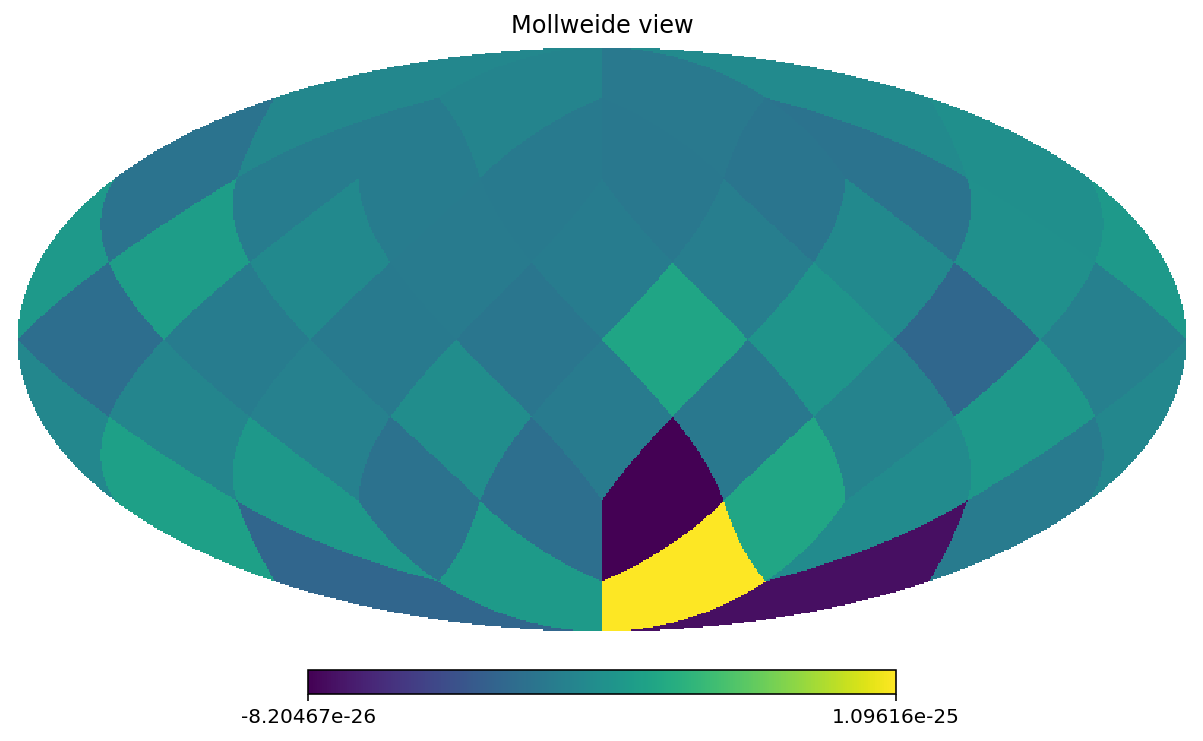

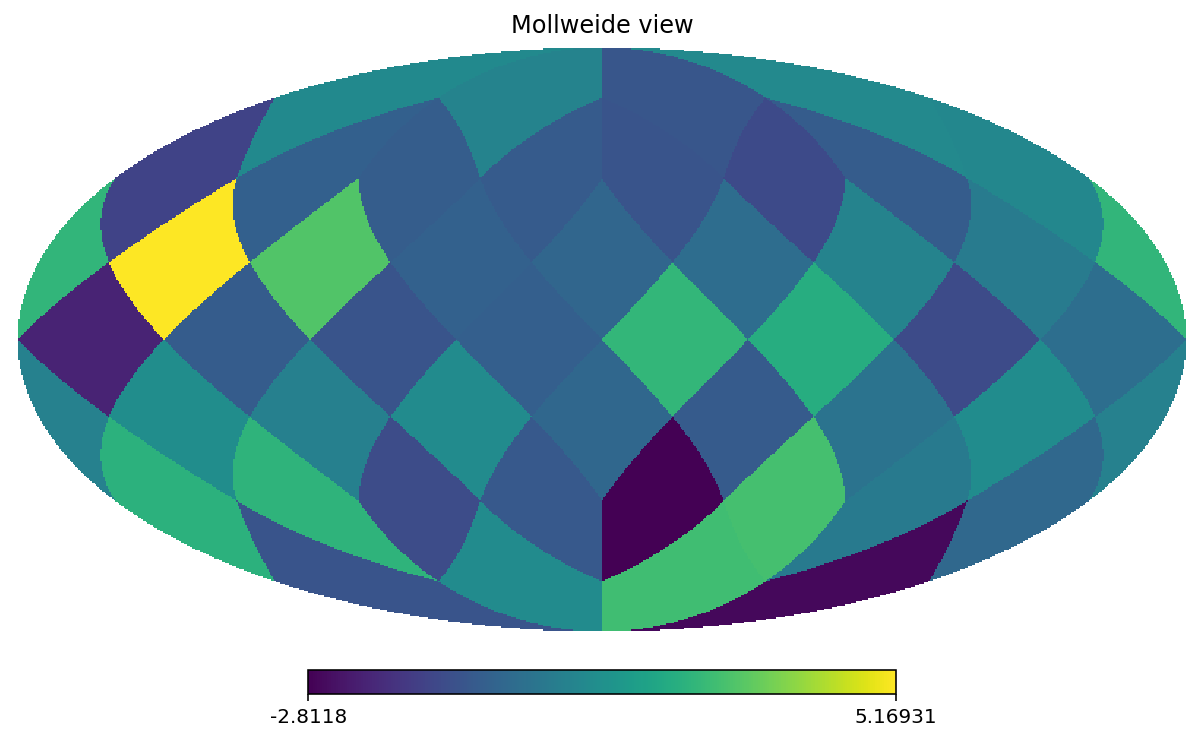

In [33]:
OS_obj.set_anisotropy_basis('pixel',2,6,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params)

hp.mollview(A2)
plt.show()

hp.mollview(A2/np.sqrt(np.diag(A2s)),)
plt.show()

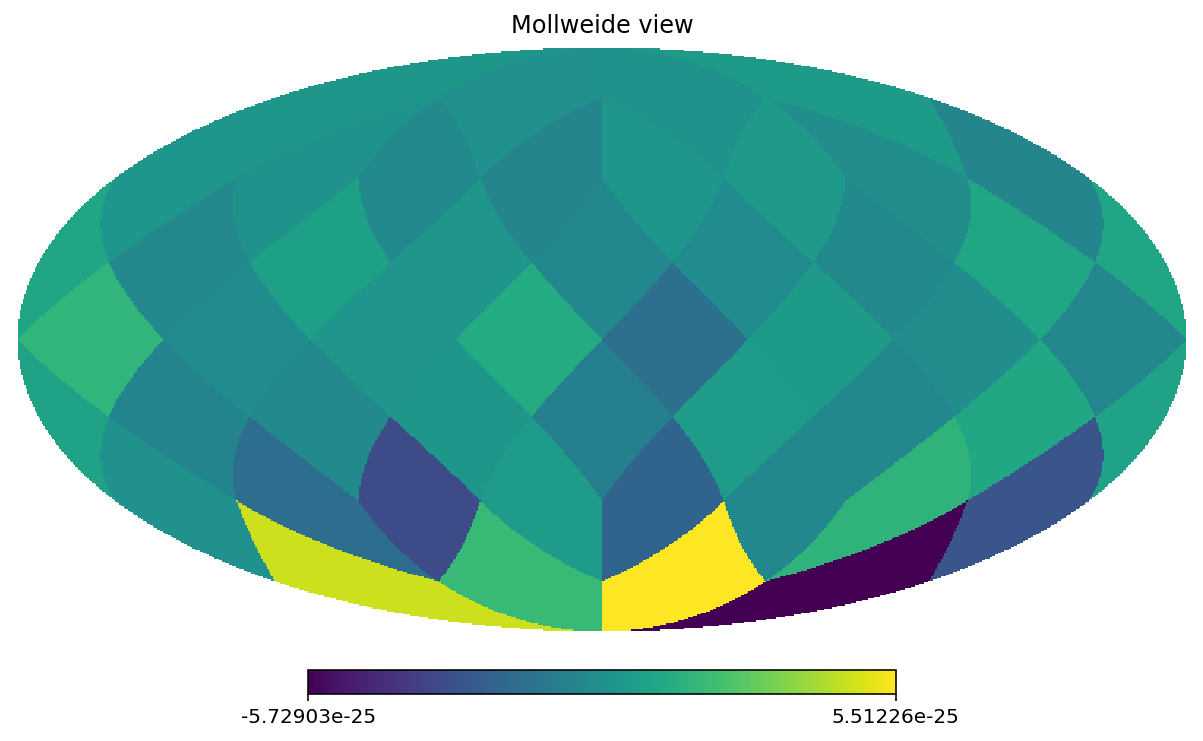

/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_64093/3491922520.py:7: RuntimeWarning: invalid value encountered in sqrt
  hp.mollview(A2/np.sqrt(np.diag(A2s)),)


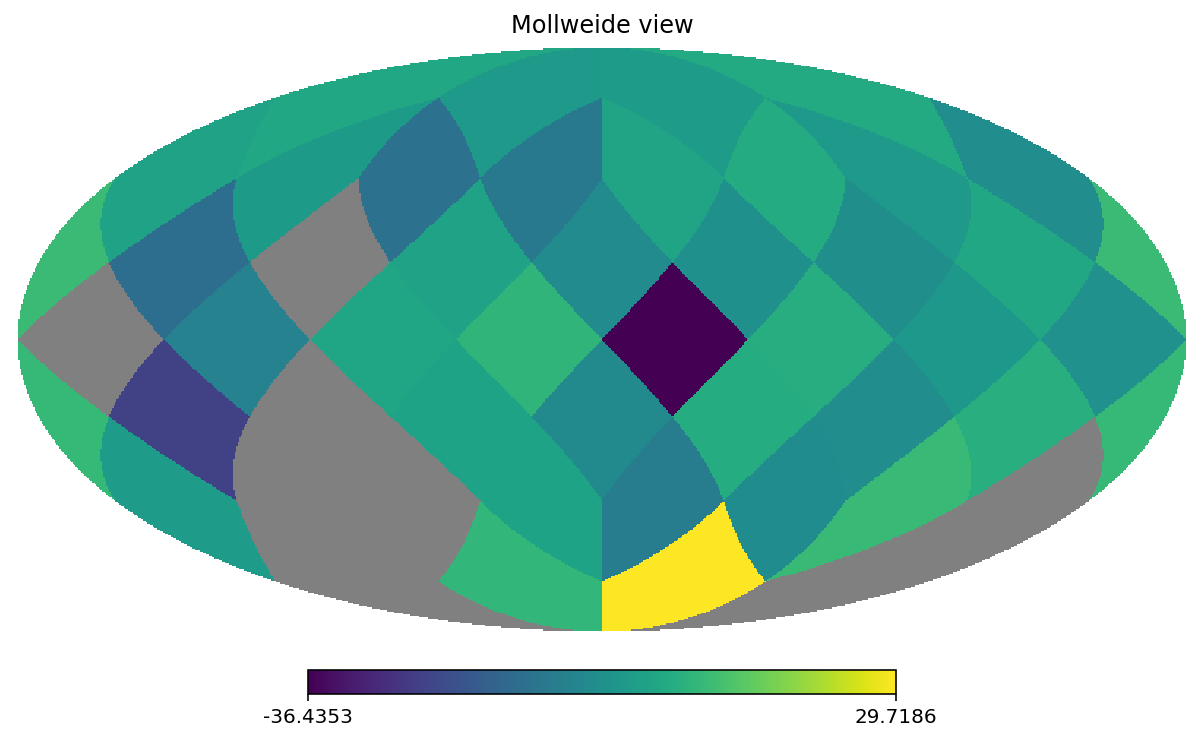

<ErrorbarContainer object of 3 artists>

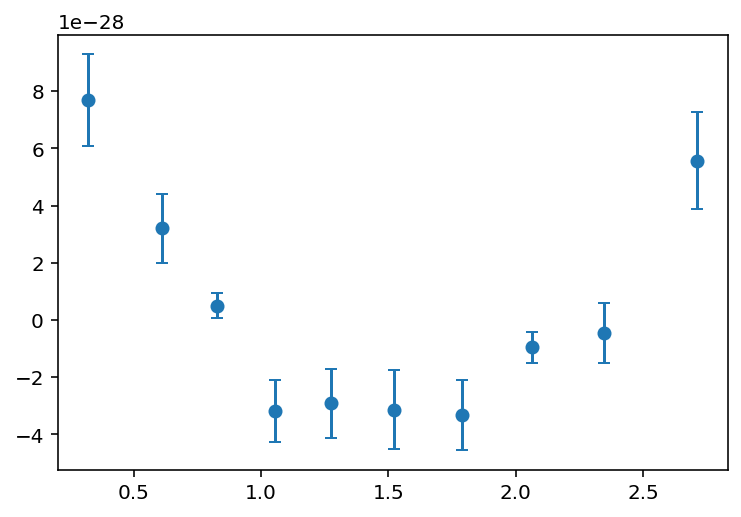

In [39]:
OS_obj.set_anisotropy_basis('pixel',2,6,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params,pair_covariance=True)

hp.mollview(A2)
plt.show()

hp.mollview(A2/np.sqrt(np.diag(A2s)),)
plt.show()

xia,rhoa,siga = utils.binned_pair_correlations(xi,rho,C,10,'hd')
plt.errorbar(xia,rhoa,siga,fmt='o',capsize=3)

#sort = np.argsort(xi)
#model = OS_obj.orf_design_matrix @ A2
#plt.plot(xi[sort],model[sort])

plt.show()

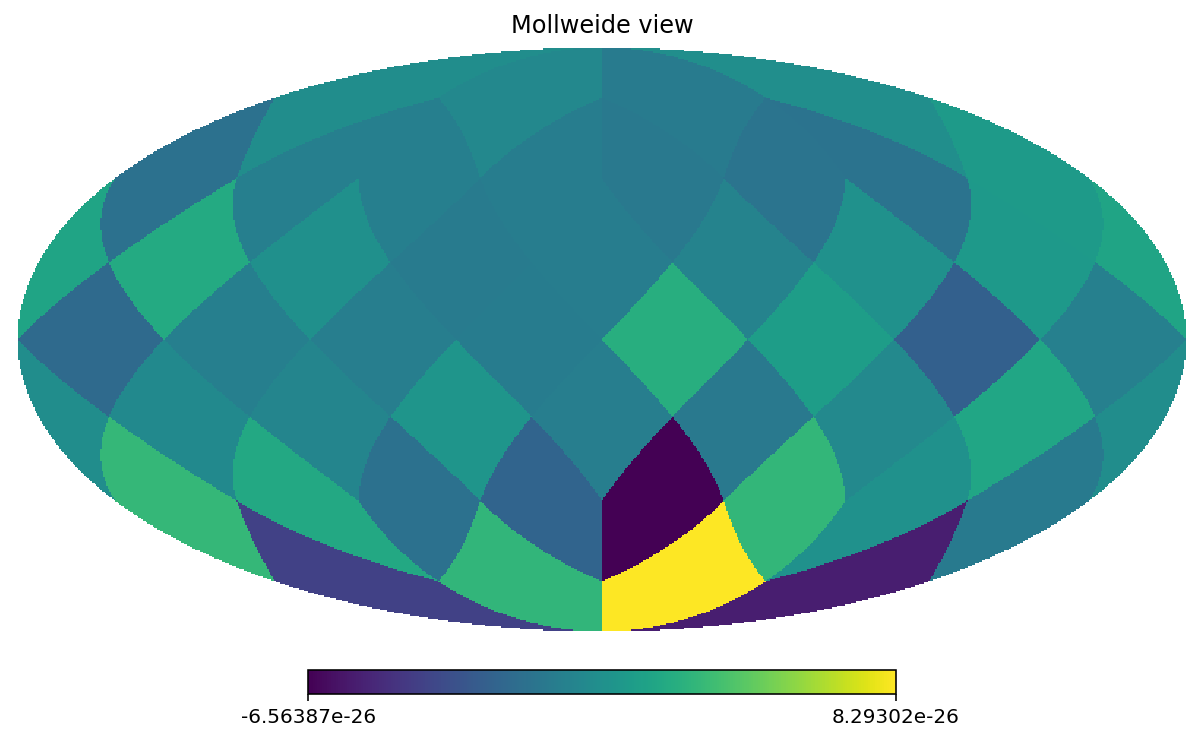

In [40]:
OS_obj.set_anisotropy_basis('spherical',2,6,'hd')
xi,rho,sig,C,A2,A2s = OS_obj.compute_OS(inj_params)

map = ac.mapFromClm(A2,OS_obj.nside)

hp.mollview(map)
plt.show()
